# Train Test Drift

In [1]:
import numpy as np
import pandas as pd

from deepchecks import Dataset
from deepchecks.checks import TrainTestDrift
import pprint
%load_ext autoreload
%autoreload 2

## Generate data

In [2]:
np.random.seed(42)

train_data = np.concatenate([np.random.randn(1000,2), np.random.choice(a=['apple', 'orange', 'banana'], p=[0.5, 0.3, 0.2], size=(1000, 2))], axis=1)
test_data = np.concatenate([np.random.randn(1000,2), np.random.choice(a=['apple', 'orange', 'banana'], p=[0.5, 0.3, 0.2], size=(1000, 2))], axis=1)

df_train = pd.DataFrame(train_data, columns=['numeric_without_drift', 'numeric_with_drift', 'categorical_without_drift', 'categorical_with_drift'])
df_test = pd.DataFrame(test_data, columns=df_train.columns)

df_train = df_train.astype({'numeric_without_drift': 'float', 'numeric_with_drift': 'float'})
df_test = df_test.astype({'numeric_without_drift': 'float', 'numeric_with_drift': 'float'})


In [3]:
df_train.head()

,numeric_without_drift,numeric_with_drift,categorical_without_drift,categorical_with_drift
0,0.496714,-0.138264,apple,apple
1,0.647689,1.523030,apple,apple
2,-0.234153,-0.234137,banana,banana
3,1.579213,0.767435,apple,banana
4,-0.469474,0.542560,orange,apple


### Insert drift into test:

In [4]:
df_test['numeric_with_drift'] = df_test['numeric_with_drift'].astype('float') + abs(np.random.randn(1000)) + np.arange(0, 1, 0.001) * 4
df_test['categorical_with_drift'] = np.random.choice(a=['apple', 'orange', 'banana', 'lemon'], p=[0.5, 0.25, 0.15, 0.1], size=(1000, 1))

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier

In [6]:
model = Pipeline([
    ('handle_cat', ColumnTransformer(
        transformers=[
            ('num', 'passthrough',
             ['numeric_with_drift', 'numeric_without_drift']),
            ('cat',
             Pipeline([
                 ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
             ]),
             ['categorical_with_drift', 'categorical_without_drift'])
        ]
    )),
    ('model', DecisionTreeClassifier(random_state=0, max_depth=2))]
)

In [7]:
label = np.random.randint(0, 2, size=(df_train.shape[0],))
df_train['target'] = label
train_dataset = Dataset(df_train, label='target')

model.fit(train_dataset.features_columns, label)

label = np.random.randint(0, 2, size=(df_test.shape[0],))
df_test['target'] = label
test_dataset = Dataset(df_test, label='target')

Automatically inferred these columns as categorical features: categorical_without_drift, categorical_with_drift. 

Automatically inferred these columns as categorical features: categorical_without_drift, categorical_with_drift. 



## Run check

Train Test Drift

Calculate drift between train dataset and test dataset.

The Drift score is a measure for the difference between two distributions, in this check - the test
 and train distributions. The check shows the drift score and distributions for the features, sorted by
 feature importance and showing only the top 5 features, according to feature importance.
 If available, the plot titles also show the feature importance (FI) rank.

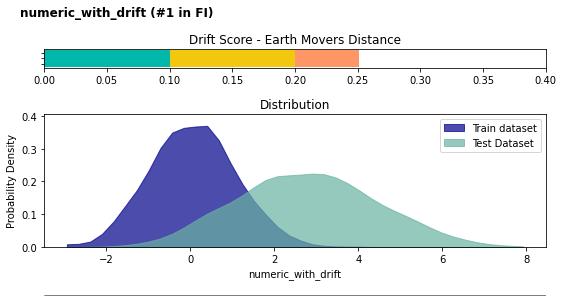

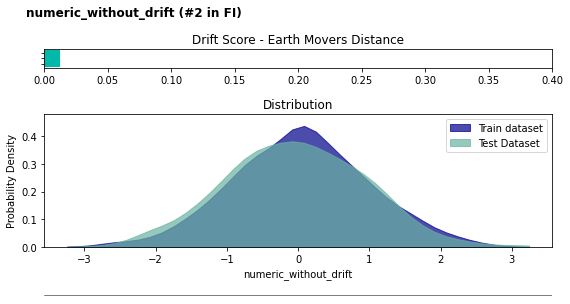

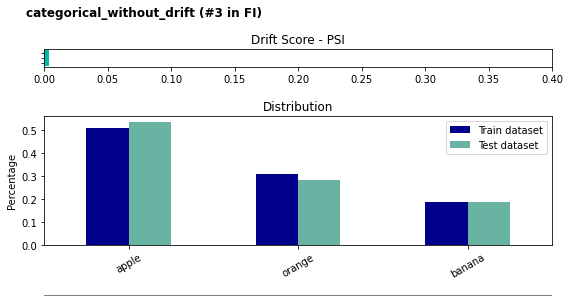

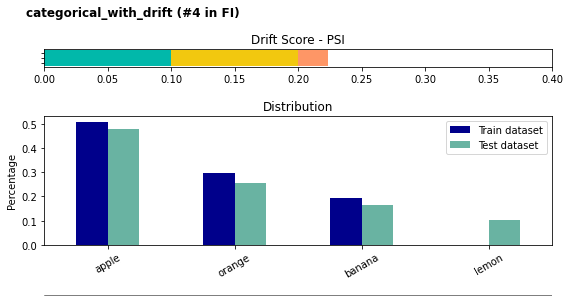

In [8]:
check = TrainTestDrift()
result = check.run(train_dataset=train_dataset, test_dataset=test_dataset, model=model)
result

In [9]:
check_cond = check.add_condition_drift_score_not_greater_than()

In [10]:
pprint.pprint([x.__dict__ for x in check_cond.conditions_decision(check_cond.run(train_dataset=train_dataset, test_dataset=test_dataset))])

[{'category': <ConditionCategory.FAIL: 'FAIL'>,
  'details': 'Found categorical columns with PSI over 0.2: '
             'categorical_with_drift\n'
             "Found numeric columns with Earth Mover's Distance over 0.1: "
             'numeric_with_drift',
  'is_pass': False,
  'name': "PSI and Earth Mover's Distance cannot be greater than 0.2 and 0.1 "
          'respectively'}]
